In [1]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import random

From Presentation 2 we learned that we may not be calculating the width of the epithelium properly. We can test if we are better calculating width if we: 

a.) Can establish a 1:1 relationship between initial_size and epithelium_width

b.) Reduce runtime from our first attempt

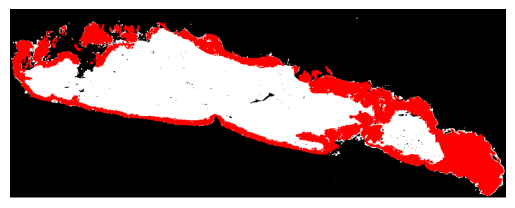

(374, 984, 3)


numpy.ndarray

In [2]:
def apply_mask():

    # Open the JPG and PNG images
    jpg_path = '/Users/kotasuzuki/Desktop/STAT390_WI2025/Presentation 2/Thinkers/Kota Suzuki/images/thumbnail.jpg' # path to the tissue slice
    png_mask_path = '/Users/kotasuzuki/Desktop/STAT390_WI2025/Presentation 2/Thinkers/Kota Suzuki/images/h1857578B  h&e_ROI_2-labels.png' # path to the epithelium slice
    
    jpg_image = Image.open(jpg_path).convert("RGB")
    png_mask = Image.open(png_mask_path).convert("RGBA")

    # Resize the mask to match the JPG dimensions if they differ
    if jpg_image.size != png_mask.size:
        png_mask = png_mask.resize(jpg_image.size, Image.LANCZOS)

    # Convert both images to numpy arrays
    jpg_array = np.array(jpg_image)
    mask_array = np.array(png_mask)

    # Create a mask for the PNG: True where the PNG is not white
    non_white_mask = ~np.all(mask_array[:, :, :3] > 200, axis=-1)  # Mask where PNG is not white

    # Create the final output image with a black background
    final_image_array = np.zeros_like(jpg_array)

    # Add white for stroma: Original white pixels in the JPG
    stroma_mask = np.all(jpg_array > 200, axis=-1)  # White pixels in JPG
    final_image_array[stroma_mask] = [0, 0, 0]  # Set stroma to white

    # Add red for mask: Areas in the PNG mask
    final_image_array[non_white_mask] = [254, 0, 0]  # Set mask areas to red
    mask = final_image_array
    # Set remaining original JPG pixels (not covered by PNG) to black
    non_masked_area = ~(stroma_mask | non_white_mask)  # Pixels not in stroma or mask
    final_image_array[non_masked_area] = [255, 255, 255]  # Set uncovered pixels to black

    # Convert back to PIL image
    final_image = Image.fromarray(final_image_array)

    return final_image, mask


   

image, mask = apply_mask()
filename = '/Users/kotasuzuki/Desktop/STAT390_WI2025/Presentation 2/Thinkers/Kota Suzuki/images/output.png' # where you want your output to go
image.save(filename)

# Display the final image
plt.imshow(image)
plt.axis("off")
plt.show()

mask[mask == 255] = 0 
# mask = Image.fromarray(mask)
# mask
print(mask.shape)
type(mask)

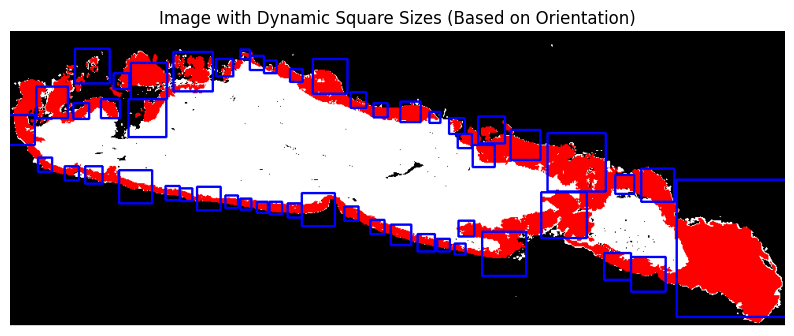

30.73076923076923
18


In [5]:
# Load the image
image_path = '/Users/kotasuzuki/Desktop/STAT390_WI2025/Presentation 2/Thinkers/Kota Suzuki/images/output.png'
image = cv2.imread(image_path)

# Function to check if a region contains black, white, and non-black-white mask
def contains_black_white_mask(region):
    contains_black = np.any(np.all(region == [0, 0, 0], axis=-1))
    contains_white = np.any(np.all(region == [255, 255, 255], axis=-1))
    contains_mask = np.any((region != [0, 0, 0]).all(axis=-1) & (region != [255, 255, 255]).all(axis=-1))
    return contains_black and contains_white and contains_mask

black_mask = cv2.inRange(image, np.array([0, 0, 0]), np.array([0, 0, 0]))
white_mask = cv2.inRange(image, np.array([255, 255, 255]), np.array([255, 255, 255]))
non_black_white_mask = mask

non_black_white_mask = np.any(non_black_white_mask>0, axis = 2).astype(int)

# Calculate distance to the nearest black and white pixels
black_distance = cv2.distanceTransform(255 - black_mask, cv2.DIST_L2, 3)
white_distance = cv2.distanceTransform(255 - white_mask, cv2.DIST_L2, 3)

# Find coordinates of non-black and non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Define the ratio tolerance range for balanced points
min_ratio, max_ratio = .7, 1.3

# Filter coordinates to only include balanced points
balanced_points = [
    coord for coord in coordinates
    if min_ratio <= (black_distance[coord[0], coord[1]] / white_distance[coord[0], coord[1]]) <= max_ratio
]

# Function to determine tissue orientation
def determine_orientation(mask):
    # Find non-zero epithelium pixels
    non_zero_coords = np.column_stack(np.where(mask > 0))
    y_min, y_max = non_zero_coords[:, 0].min(), non_zero_coords[:, 0].max()
    x_min, x_max = non_zero_coords[:, 1].min(), non_zero_coords[:, 1].max()
    # Compare height and width of the bounding box
    height = y_max - y_min
    width = x_max - x_min
    return "vertical" if height > width else "horizontal"

### CHANGE HERE: same logic but allowing three 0s in binary array 
### to allow some white/black to be included between 1s 

# This code currently takes the "width" at two different locations of the epithelium 
# also it iterates within a for loop which is super inefficient 

def calculate_epithelium_width(row_or_col, mask, orientation):
    if orientation == "horizontal":
        # Use vertical slice for horizontally oriented tissue
        slice_mask = mask[:, row_or_col]
    else:
        # Use horizontal slice for vertically oriented tissue
        slice_mask = mask[row_or_col, :]

    # Convert the mask slice to binary (0 or 1)
    binary_slice = (slice_mask > 0).astype(int)

    max_width = 0
    current_width = 0
    zero_count = 0  
    inside_region = False  # Track if we are inside a valid 1s region

    for value in binary_slice:
        if value == 1:
            current_width += 1
            zero_count = 0  
            inside_region = True 
        else:
            if inside_region:  # Only count zeros inside a valid region
                zero_count += 1
                if zero_count <= 5:  # Allow up to 5 consecutive zeros **inside** the region
                    current_width += 1
                else:
                    max_width = max(max_width, current_width)  
                    current_width = 0
                    zero_count = 0
                    inside_region = False  

    max_width = max(max_width, current_width)

    return max_width



### CHANGING OVERLAP CALCULATION TO DIVIDE NEW BY OLD 
def calculate_overlap(new_coords, existing_coords):
    if len(new_coords.intersection(existing_coords)) == 0:
        return 0 
    else:
        overlap = len(new_coords) / len(new_coords.intersection(existing_coords))
        return overlap

# Initialize variables
max_attempts = 1000
covered_coordinates = set()
rectangles = []
attempts = 0

# Start generating squares using only balanced points as starting locations
while len(balanced_points) > 0 and attempts < max_attempts:
    attempts += 1
    # Randomly select a new center point for the square from balanced points
    random.seed(attempts)
    random_coord = random.choice(balanced_points)
    center_x, center_y = int(random_coord[1]), int(random_coord[0])

    ### KOTA NEW: Extract a local mask around the center point
    local_size = 30
    local_top, local_bottom = max(0, center_y - local_size // 2), min(non_black_white_mask.shape[0], center_y + local_size // 2)
    local_left, local_right = max(0, center_x - local_size // 2), min(non_black_white_mask.shape[1], center_x + local_size // 2)
    
    # Create a local mask based on this region
    local_mask = non_black_white_mask[local_top:local_bottom, local_left:local_right]
    
    # Determine local orientation dynamically
    tissue_orientation = determine_orientation(local_mask)
    # print(f"Local orientation at ({center_x}, {center_y}): {tissue_orientation}")

    # Dynamically calculate the initial_size based on epithelium width
    if tissue_orientation == "horizontal":
        epithelium_width = calculate_epithelium_width(center_x, non_black_white_mask, tissue_orientation)
    else:
        epithelium_width = calculate_epithelium_width(center_y, non_black_white_mask, tissue_orientation)

    initial_size = round(1.5 * epithelium_width) ### MAKING INITIAL SIZE PURPOSEFULLY BIGGER
    num_squares_drawn = 0
    vertical_preference = False

    # Expansion phase for square
    while True:

        # WHAT IF WE START BIG AND SHRINK?
        size = initial_size - num_squares_drawn
        top, bottom = center_y - size // 2, center_y + size // 2
        left, right = center_x - size // 2, center_x + size // 2
        if size == epithelium_width:  # Stop when reaching the target width
            break
        
        # Define regions at each corner of the square
        corner_checks = {
            "top_left": (top, left),
            "top_right": (top, right - initial_size),
            "bottom_left": (bottom - initial_size, left),
            "bottom_right": (bottom - initial_size, right - initial_size)
        }

        # Track how many corners are outside the mask
        corners_outside_count = 0

        for corner_name, (corner_y, corner_x) in corner_checks.items():
            # Ensure the region is within the image bounds
            if corner_y < 0 or corner_x < 0 or corner_y + initial_size > image.shape[0] or corner_x + initial_size > image.shape[1]:
                corners_outside_count += 1
                continue

            # Extract the corner region in the mask at this corner
            corner_region = non_black_white_mask[corner_y:corner_y + initial_size, corner_x:corner_x + initial_size]
            if not np.any(corner_region):
                corners_outside_count += 1

            if corners_outside_count >= 2:
                break

        if corners_outside_count >= 2:
            break  # Stop expanding

        num_squares_drawn += 1
        if num_squares_drawn > 25:  # Limit expansion if square becomes too large
            break

    # Get all coordinates in the current square
    new_square_coords = set((y, x) for y in range(max(0, top), min(image.shape[0], bottom))
                                    for x in range(max(0, left), min(image.shape[1], right)))
    # Check overlap with existing covered coordinates
    if calculate_overlap(new_square_coords, covered_coordinates) <= 1:
        covered_coordinates.update(new_square_coords)
        rectangles.append((left, top, right, bottom))

        # Draw the rectangle
        color = (0, 255, 0) if vertical_preference else (255, 0, 0)
        cv2.rectangle(image, (left, top), (right, bottom), color, 2)

        # Remove these coordinates from the non-black-white mask list and balanced points
        coordinates = np.array([coord for coord in coordinates if tuple(coord) not in new_square_coords])
        balanced_points = [coord for coord in balanced_points if tuple(coord) not in new_square_coords]

# Display the resulting image with all rectangles
plt.figure(figsize=(10, 10))
plt.title("Image with Dynamic Square Sizes (Based on Orientation)")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

lengths = []

# Print dimensions of each final rectangle as Length x Width
for i, (left, top, right, bottom) in enumerate(rectangles, 1):
    length = bottom - top  # Height of the rectangle
    width = right - left   # Width of the rectangle
    lengths.append(length)
    
    #print(f"Rectangle {i} dimensions: Length = {length} pixels, Width = {width} pixels")

import statistics as st
print(np.mean(lengths))
print(st.mode(lengths))

Find a way to use as many C functions and not python functions (more time efficient)

Try to store the epithelium width value at a coordinate so that if we discard a patch, we can look back and reference it for another patch close to it. 

The epithelium width calculation is done at a SLICE. This means that maximum width is calcualted at two locations. Change that. 